## Table of contents

1 [Markov Chain Monte Carlo (MCMC)](#Markov-Chain-Monte-Carlo-(MCMC))

2 [Least Squares Method with Bootstrap](#Least-Squares-Method-with-Bootstrap)

3 [Method comparison](#Method-comparison)

In [28]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import linearRegression_1
import math
import random
import warnings
warnings.filterwarnings("ignore")
from numpy import linalg as lg
from scipy.optimize import least_squares
import scipy.stats as st


from mcmc import mcmc
import densities
import my_problemLR


%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Markov Chain Monte Carlo (MCMC)

## Parameter for the problem

In [29]:
# random seed for results recreation
np.random.seed(0)

# parameters for the problem
Npoint = 500

# data abscissa {Xi}
my_problemLR.Xi = np.random.rand(Npoint)
my_problemLR.sigmad = 0.1 # sec

## Linear regression coefficients to be found

In [30]:
slope = 2.
intercept = 1.

## Create "observed data"

The goal of this exercise is to compute a linear regression onto a dataset of random points in order to compute the coefficients of the following equation:

\begin{equation}
    y = Ax + B 
\end{equation}

With A the slope and B the intercept. In this notebook, the value A = 2 and B = 1 were chosen.
To get our initial data, we produce n random x from 0 to 1 using the equation above to get random y and adding noise to it using a normal probability distribution.

<IPython.core.display.Javascript object>


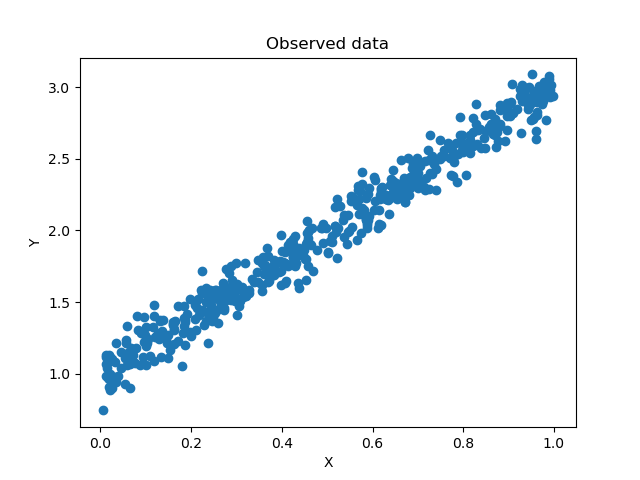

Text(0, 0.5, 'Y')

In [31]:
#  Data value = {Yi}
my_problemLR.Yi = slope * my_problemLR.Xi + intercept + np.random.randn(Npoint) * my_problemLR.sigmad

plt.figure()
plt.plot(my_problemLR.Xi,my_problemLR.Yi,'o')
plt.title('Observed data')
plt.xlabel('X')
plt.ylabel('Y')

## Trial solution

In [32]:
X0 = np.array([10., 10.])

## Run MCMC with different likelihood distributions

The MCMC method was used with 2 types of residuals likelihood (res being the residuals):

Gaussian
\begin{equation}
    l = -0.5 * \sum\ res^{2}
    \label{Gauss}
\end{equation}

Exponential

\begin{equation}
    l = -1 * \sum\ | res |
    \label{Expo}
\end{equation}

A logprior was also set to contraint the system , the values set were:

\begin{equation}
  lp =\begin{cases}
    0 & \text{if 0 < (a,b) < 10.5}\\
    - \infty , & \text{else}
  \end{cases}
\end{equation}

In [33]:
step = np.array([0.01, 0.01])# *2 or *5 or *10

niter = 100000


mout_gauss, mMAP_gauss, accrate_gauss = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                                             densities.generate, densities.logproposal, X0, niter, step, 'Gaus')

mout_exp, mMAP_exp, accrate_exp = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                                          densities.generate, densities.logproposal, X0, niter, step, 'Exp')

## Plot solutions

<IPython.core.display.Javascript object>


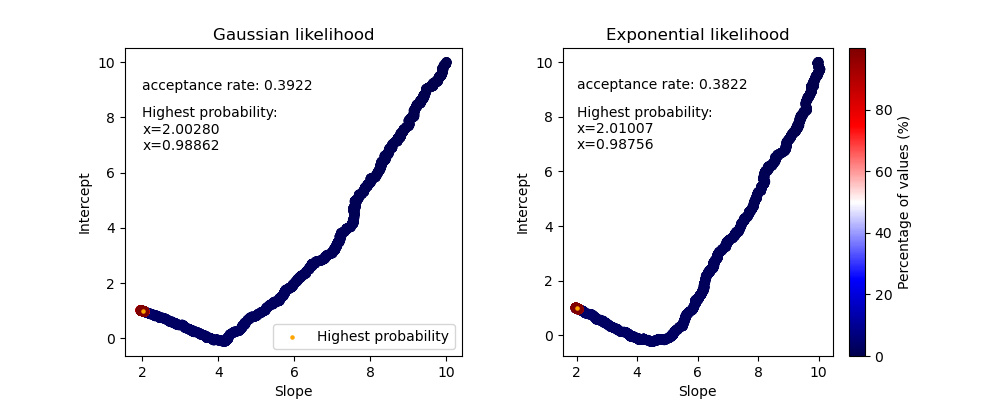

In [34]:
x_gauss = mout_gauss[:, 0]
y_gauss = mout_gauss[:, 1]

x_exp = mout_exp[:, 0]
y_exp = mout_exp[:, 1]

plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.title('Gaussian likelihood')
plt.text(2, 9, 'acceptance rate: %.4f' %accrate_gauss)
plt.text(2, 8, 'Highest probability:')
plt.text(2, 7.4, 'x=%.5f' %mMAP_gauss[0])
plt.text(2, 6.8, 'x=%.5f' %mMAP_gauss[1])
plt.scatter(x_gauss, y_gauss,cmap=plt.get_cmap('seismic'), c = np.arange(len(x_gauss))/len(x_gauss)*100)
plt.scatter(mMAP_gauss[0], mMAP_gauss[1], color='orange', s=5, label='Highest probability')
plt.legend(loc='lower right')
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.subplot(122)
plt.title('Exponential likelihood')
plt.text(2, 9, 'acceptance rate: %.4f' %accrate_exp)
plt.text(2, 8, 'Highest probability:')
plt.text(2, 7.4, 'x=%.5f' %mMAP_exp[0])
plt.text(2, 6.8, 'x=%.5f' %mMAP_exp[1])
plt.scatter(x_exp, y_exp,cmap= plt.get_cmap('seismic'), c = np.arange(len(x_exp))/len(x_exp)*100)
plt.xlabel('Slope')
plt.ylabel('Intercept')
plt.subplots_adjust(wspace=0.3)
cb = plt.colorbar()
cb.set_label('Percentage of values (%)')
plt.scatter(mMAP_exp[0], mMAP_exp[1], color='orange', s=5, label='Highest probability')

The chain starts at point (10, 10) and ends around point (2, 1). The color illustrates the density of points. Important is to note the low percentage values until the chain approaches (2, 1). This part is known as the burn-in chain where the chain has not converged to the dense part of the probability distribution yet and is oversampling low probability area. Then, we can see a high density area around the point (2, 1) known as the posterior chain where the chain settled into the equilibrium solution, each step is a sample of the target distribution. We will have to determine the burn-in chain and delete it from the overall chain.

The two chains with Gaussian and exponential residual distributions have very similar paths.

## Defining the burning period

<IPython.core.display.Javascript object>


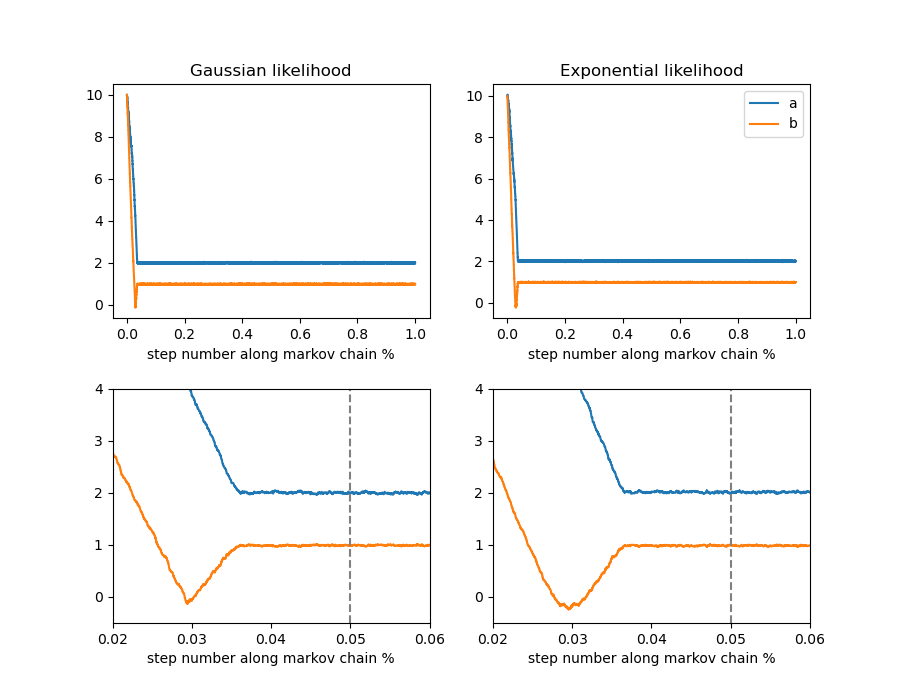

In [35]:
iter_=np.arange(0.,niter)

plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.title('Gaussian likelihood')
plt.plot(iter_/niter, x_gauss,iter_/niter,y_gauss)
plt.xlabel('step number along markov chain %')
plt.subplot(222)
plt.title('Exponential likelihood')
lineObjects = plt.plot(iter_/niter, x_exp,iter_/niter,y_exp)
plt.xlabel('step number along markov chain %')
plt.legend(iter(lineObjects), ('a', 'b'))
plt.subplot(224)
plt.plot(iter_/niter, x_exp,iter_/niter,y_exp)
plt.xlabel('step number along markov chain %')
plt.xlim([0.02, 0.06])
plt.ylim([-0.5, 4])
plt.axvline(0.05, color='gray', LineStyle='--')
plt.subplot(223)
plt.plot(iter_/niter, x_gauss,iter_/niter,y_gauss)
plt.xlabel('step number along markov chain %')
plt.xlim([0.02, 0.06])
plt.ylim([-0.5, 4])
plt.axvline(0.05, color='gray', LineStyle='--')
plt.subplots_adjust(hspace=0.3)

Lower panels of the plot above are zoomed-in views of upper panels, focused on the stabilisation period.

We detect the posterior chain where the above curve stabilises. We chose a threshold of 0.05 (5%) to remove the burn-in chain (gray dashed line in plot above). The same threshold is used for Gaussian and exponential likelihoods.

## Removing the burning period

In [36]:
burning_period = int(0.05*niter)

a_gauss = mout_gauss[burning_period:-1,0]
b_gauss = mout_gauss[burning_period:-1,1]

a_exp = mout_exp[burning_period:-1,0]
b_exp = mout_exp[burning_period:-1,1]

print('Length of the true Markov Chain after removal of the burning period: %d' % len(a_exp))

Length of the true Markov Chain after removal of the burning period: 94999


## Defining approximately the correlation length

<IPython.core.display.Javascript object>


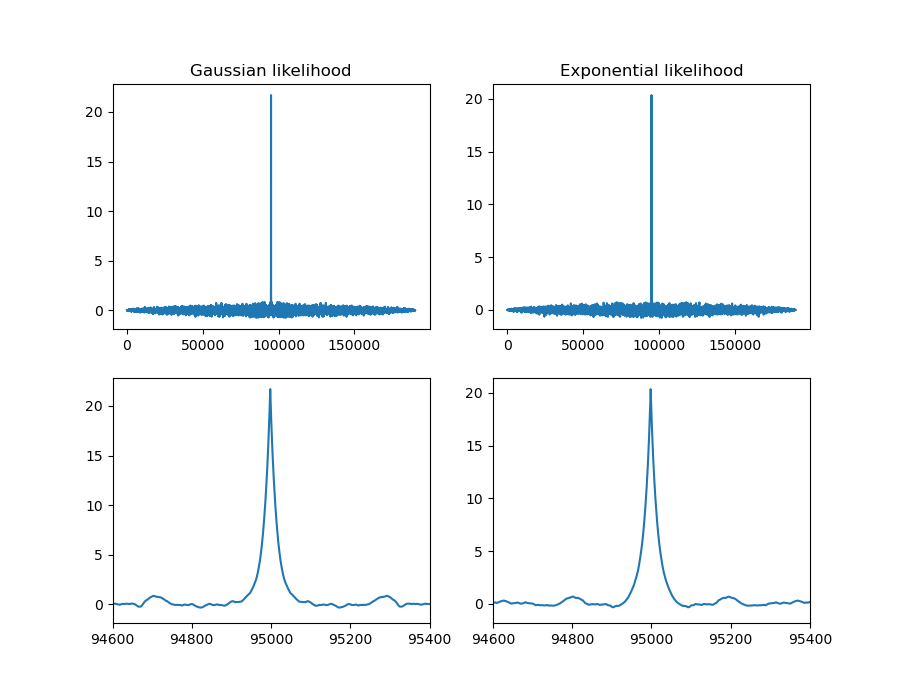

(94600.0, 95400.0)

In [37]:
import scipy.signal as sig

plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.title('Gaussian likelihood')
plt.plot(sig.correlate(a_gauss-np.mean(a_gauss),a_gauss-np.mean(a_gauss)))
plt.subplot(223)
plt.plot(sig.correlate(a_gauss-np.mean(a_gauss),a_gauss-np.mean(a_gauss)))
plt.xlim([95000-400, 95000+400])
plt.subplot(222)
plt.title('Exponential likelihood')
plt.plot(sig.correlate(a_exp-np.mean(a_exp),a_exp-np.mean(a_exp)))
plt.subplot(224)
plt.plot(sig.correlate(a_exp-np.mean(a_exp),a_exp-np.mean(a_exp)))
plt.xlim([95000-400, 95000+400])

Lower panels of the plot above are zoomed-in views of upper panels, focused on the central part of the plot.

The central peak is approximatively $\pm$200 values wide (correlation length). We wil therefore only take every 200th value. Again, the same value is used for Gaussian and exponential likelihoods.

## Getting rid of correlation

In [39]:
a_gauss_true=a_gauss[0:-1:200]
b_gauss_true=b_gauss[0:-1:200]

a_exp_true=a_exp[0:-1:200]
b_exp_true=b_exp[0:-1:200]

print('Length of the true Markov Chain after getting rid of correlation (and burning period): %d' % len(a_exp_true))

Length of the true Markov Chain after getting rid of correlation (and burning period): 475


<IPython.core.display.Javascript object>


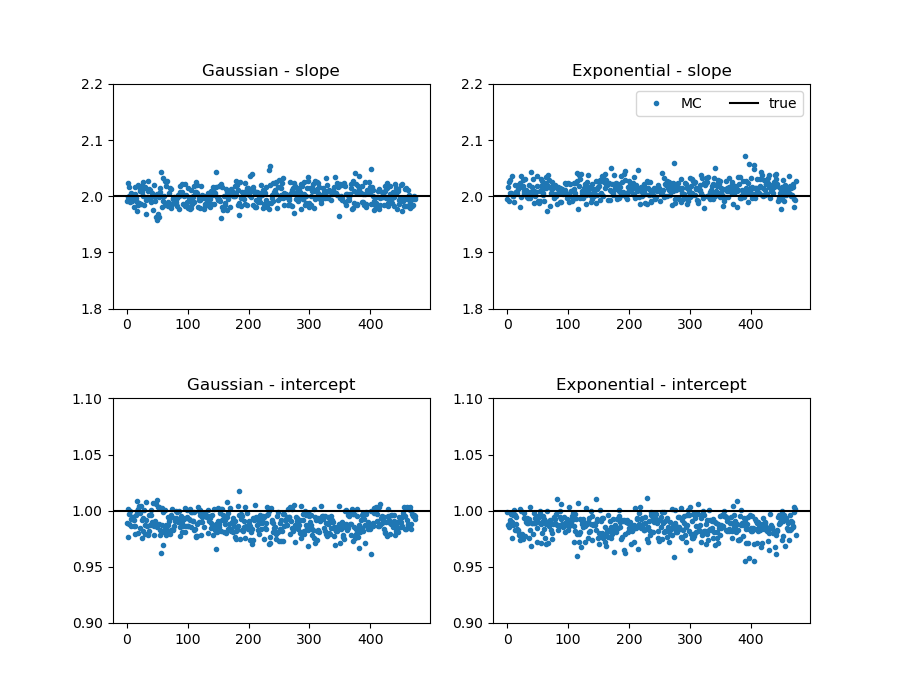

In [40]:
plt.figure(figsize=(9, 7))

plt.subplot(221)
plt.plot(a_gauss_true,'.',label='MC a')
plt.title('Gaussian - slope')
plt.ylim(1.8,2.2)
plt.axhline(2,c='black',label='true a')
plt.subplot(222)
plt.plot(a_exp_true,'.',label='MC')
plt.title('Exponential - slope')
plt.ylim(1.8,2.2)
plt.axhline(2,c='black',label='true')
plt.legend(ncol=2,loc='upper right')
plt.subplot(223)
plt.plot(b_gauss_true,'.',label='MC b')
plt.title('Gaussian - intercept')
plt.ylim(0.9,1.1)
plt.axhline(1,c='black',label='true b')
plt.subplot(224)
plt.plot(b_exp_true,'.',label='MC b')
plt.title('Exponential - intercept')
plt.ylim(0.9,1.1)
plt.axhline(1,c='black',label='true b')
plt.subplots_adjust(hspace=0.4)

## Represent histogram for slope and intercept

<IPython.core.display.Javascript object>


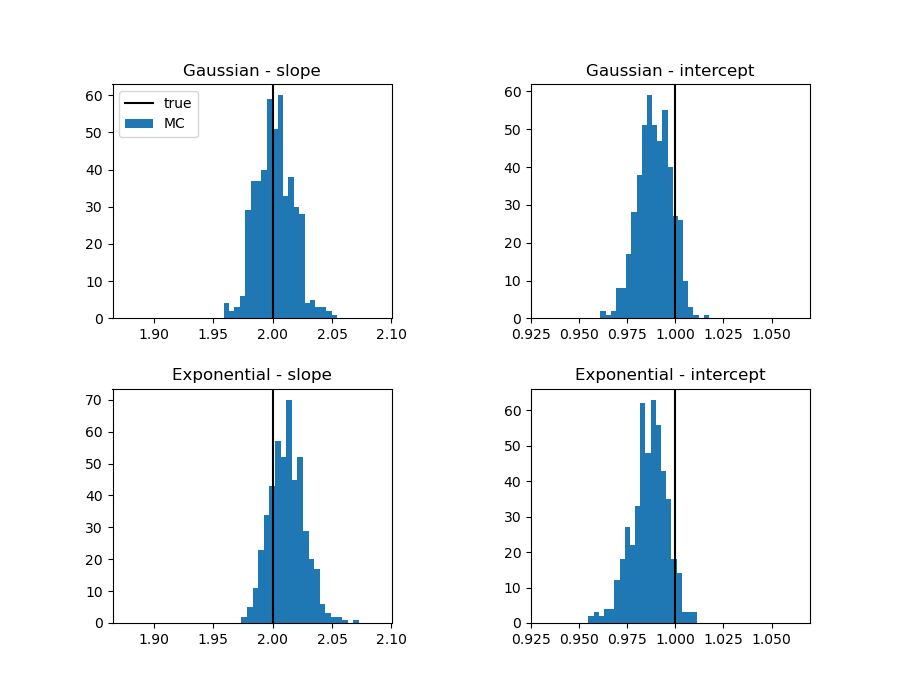

In [41]:
plt.figure(figsize=(9, 7))
plt.subplot(221)
plt.title('Gaussian - slope')
ha = plt.hist(a_gauss_true, int(np.sqrt(np.shape(a_gauss_true)[0])), label='MC')
plt.xlim([1.93, 2.07])
plt.axvline(2, color='black', label='true')
plt.legend(loc='upper left')
plt.subplot(222)
plt.title('Gaussian - intercept')
hb = plt.hist(b_gauss_true, int(np.sqrt(np.shape(b_gauss_true)[0])))
plt.xlim([0.95, 1.05])
plt.axvline(1, color='black')
plt.subplot(223)
plt.title('Exponential - slope')
ha = plt.hist(a_exp_true, int(np.sqrt(np.shape(a_exp_true)[0])))
plt.xlim([1.93, 2.07])
plt.axvline(2, color='black')
plt.subplot(224)
plt.title('Exponential - intercept')
hb = plt.hist(b_exp_true, int(np.sqrt(np.shape(b_exp_true)[0])))
plt.xlim([0.95, 1.05])
plt.axvline(1, color='black')
plt.subplots_adjust(wspace=0.5, hspace=0.3)

In [42]:
print('Mean solution with Gaussian likelihood:')
print('Slope: %.5f \u00B1 %.5f' %(np.nanmean(a_gauss_true), np.nanstd(a_gauss_true)))
print('Intercept: %.5f \u00B1 %.5f' %(np.nanmean(b_gauss_true), np.nanstd(b_gauss_true)))

Mean solution with Gaussian likelihood:
Slope: 2.00170 ± 0.01547
Intercept: 0.98927 ± 0.00866


In [43]:
print('Mean solution with Exponential likelihood:')
print('Slope: %.5f \u00B1 %.5f' %(np.nanmean(a_exp_true), np.nanstd(a_exp_true)))
print('Intercept: %.5f \u00B1 %.5f' %(np.nanmean(b_exp_true), np.nanstd(b_exp_true)))

Mean solution with Exponential likelihood:
Slope: 2.01211 ± 0.01470
Intercept: 0.98638 ± 0.00926


## Distribution of posterior density function

Here we test different distributions for the posterior density function using the Kolmogorov-Smirnov test.

In [44]:


def get_best_distribution(data):
    
    dist_names = ['weibull_min','norm','weibull_max','beta',
              'invgauss','uniform','gamma','expon',   
              'lognorm','pearson3','triang']
    
    dist_results = []
    
    params = {}
    pvalues = []
    for dist_name in dist_names:
        dist = getattr(st, dist_name)
        param = dist.fit(data)

        params[dist_name] = param
        
        # Applying the Kolmogorov-Smirnov test
        D, p = st.kstest(data, dist_name, args=param)
        # print("p value for "+dist_name+" = "+str(p))
        # print('D=%.3f' % D)
        dist_results.append((dist_name, p))
        pvalues.append(p)
        
    # select the best fitted distribution
    best_dist, best_p = (max(dist_results, key=lambda item: item[1]))
    # store the name of the best fit and its p value

    print("Best fitting distribution: "+str(best_dist))
    print("Best p value: "+ str(best_p))
    print("Parameters for the best fit: "+ str(params[best_dist]))
    
    #results visualisation
    plt.figure(figsize=(10,6))
    plt.plot(pvalues, 'o--')
    plt.ylabel('pvalue')
    plt.xticks(np.arange(0,len(dist_names)), dist_names, rotation=45)
    plt.axvline(np.where(pvalues == best_p)[0][0], LineStyle='--', color='red')
    
    return best_dist, best_p, params[best_dist]


GAUSSIAN - SLOPE:
Best fitting distribution: pearson3
Best p value: 0.8567137978942689
Parameters for the best fit: (0.1722643432856819, 2.0016962456082137, 0.015468947824194775)


<IPython.core.display.Javascript object>


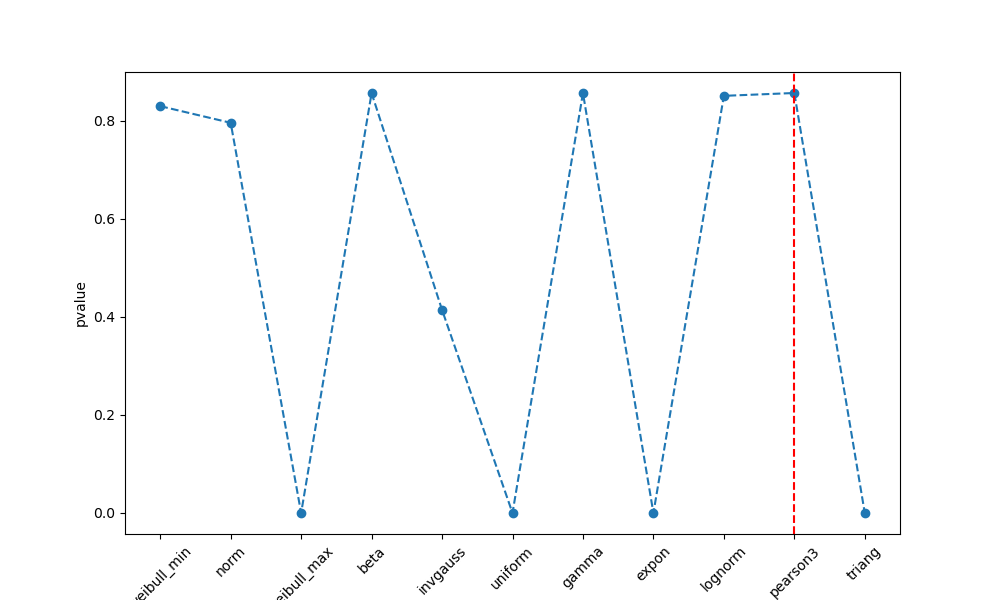



GAUSSIAN - INTERCEPT:
Best fitting distribution: weibull_max
Best p value: 0.9071905688049648
Parameters for the best fit: (3.829970627322324, 1.0196376457920953, 0.033548719726927634)


<IPython.core.display.Javascript object>


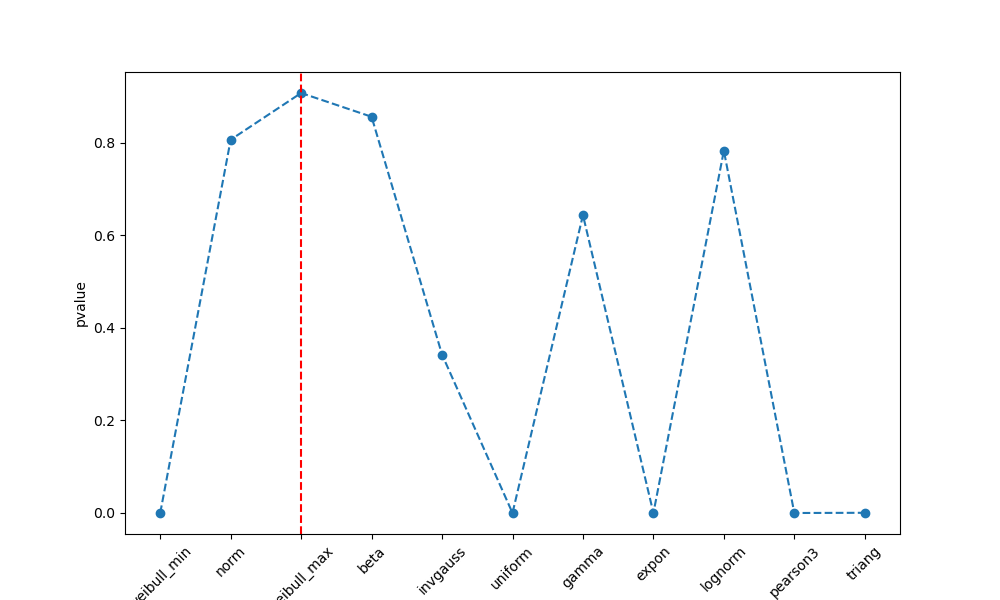

In [45]:
print('GAUSSIAN - SLOPE:')
gs = get_best_distribution(a_gauss_true)
print('\n')
print('GAUSSIAN - INTERCEPT:')
gi = get_best_distribution(b_gauss_true)

EXPONENTIAL - SLOPE:
Best fitting distribution: beta
Best p value: 0.9381163893983199
Parameters for the best fit: (41.011268932037225, 2003577.4361478523, 1.9180118375793427, 4597.045808243106)


<IPython.core.display.Javascript object>


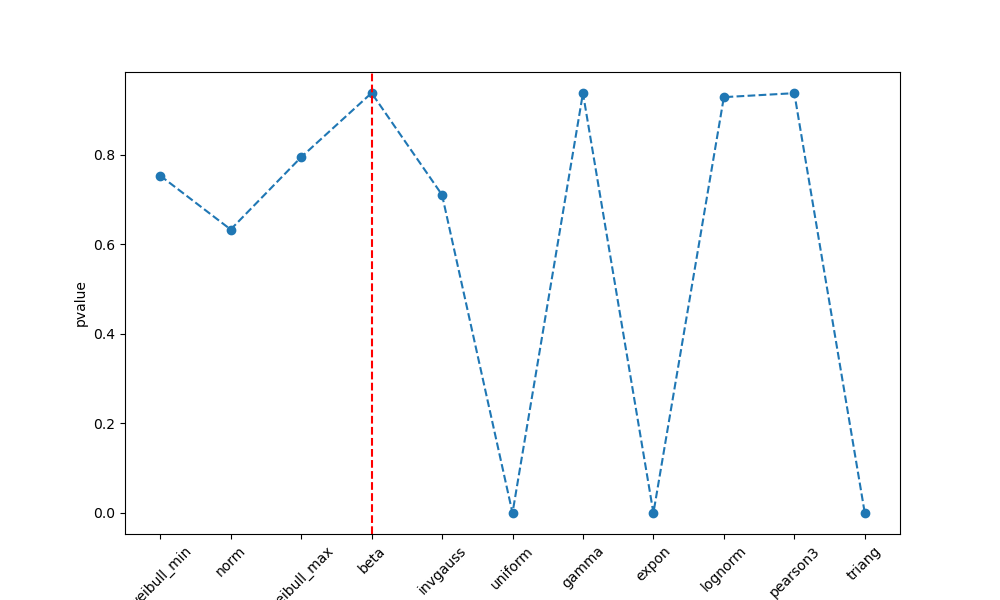



EXPONENTIAL - INTERCEPT:
Best fitting distribution: beta
Best p value: 0.5267387327710389
Parameters for the best fit: (105871371.00943384, 17.752784413792632, -238493.46214232402, 238494.48849374382)


<IPython.core.display.Javascript object>


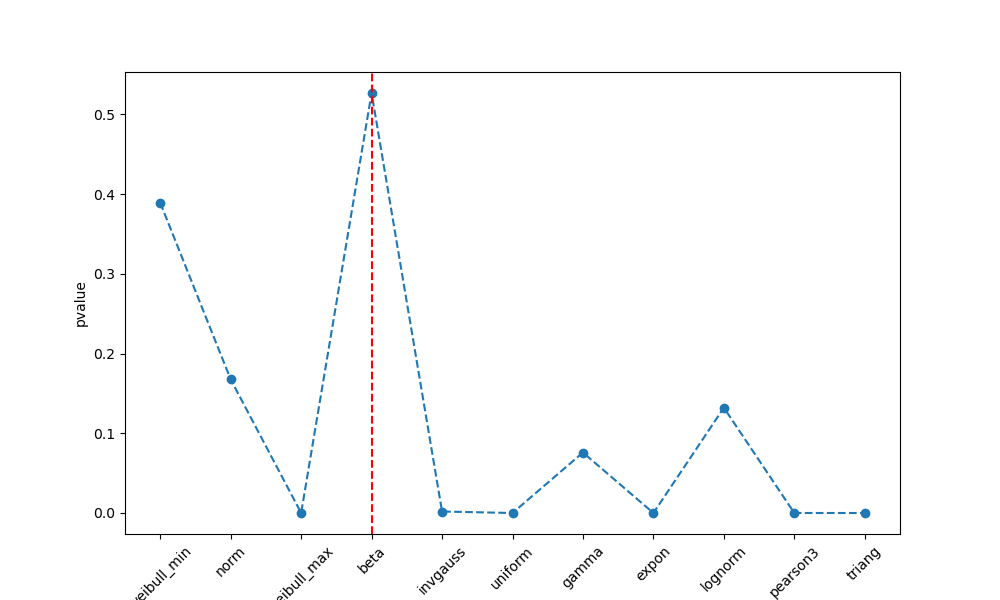

In [48]:
print('EXPONENTIAL - SLOPE:')
es = get_best_distribution(a_exp_true)
print('\n')
print('EXPONENTIAL - INTERCEPT:')
ei = get_best_distribution(b_exp_true)

# Least Squares Method with Bootstrap

The least squared method was computed using multiple subdataset of our prior dataset using the bootstrap method(ie: Replacing 10\% of our dataset by randomly sampling in the remaining 90\%) with n = 1000 iterations. The least squared method use a cost function expressed as followed : 

\begin{equation}
    Val = \sqrt{\sum\ res^2}
    \label{Expo}
\end{equation}

In [49]:
# create artificial data
n = 100
x=np.random.rand(n)
# We want to guess the slope + intercept of the line of equation y=a*x+b
a=2.
b=1.
y = a*x + b + np.random.randn(n)*0.1

In [50]:
x2 = np.array(list(x))
y2 = np.array(list(y))
# plt.figure()
slopes = []
intercepts = []

iters = 1000

for i in range(iters):
    
    pop = np.random.randint(0,len(x) , size=math.ceil(len(x2)/10))
    x3 = np.delete(x2, pop)
    y3 = np.delete(y2, pop)
    add = np.random.randint(0, len(x3), size = len(x2)-len(x3))
    
    x3 = np.append(x3, x3[add])
    y3 = np.append(y3, y3[add])
    
    sol = minimize(fun=linearRegression_1.mycost,x0=np.array([10,10]),args=(x3,y3,2),method='Nelder-Mead')
    #sol = least_squares(residual,np.zeros(2,),method='lm')

    def getGMatrix(x,order):

        N=len(x)
        G=np.ones((N,order+1))

        for i in range(0,order):

            G[:,i]=x**float(order-i)


        return G

    G=getGMatrix(x3,1)
    Gt=G.transpose()
    rhs=np.matmul(Gt,y3) 
    lhs=np.matmul(Gt,G)
    m=lg.solve(lhs,rhs)
    
    slopes.append(m[0])
    intercepts.append(m[1])
    #slopes.append(sol.x[0])
    #intercepts.append(sol.x[1])

<IPython.core.display.Javascript object>


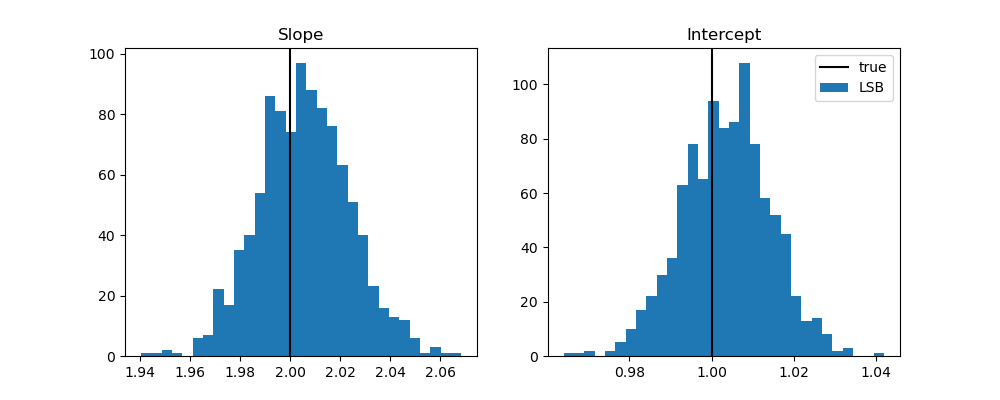

In [51]:
# Results visualisation
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.hist(slopes, bins=int(np.sqrt(iters)))
plt.axvline(2, color='black')
plt.title('Slope')
plt.subplot(122)
plt.hist(intercepts, bins=int(np.sqrt(iters)), label='LSB')
plt.title('Intercept')
plt.axvline(1, color='black', label='true')
plt.legend(loc='upper right')

In [53]:
print('Mean slope: %.3f \u00B1 %.3f' %(np.mean(slopes), np.std(slopes)))
print('Mean intercept: %.3f \u00B1 %.3f' %(np.mean(intercepts), np.std(intercepts)))

Mean slope: 2.006 ± 0.018
Mean intercept: 1.004 ± 0.011


# Method comparison

## Rerun MCMC method on similar data

All the steps described and discussed in the MCMC section are here grouped in one function 

In [54]:
def MCMC(ind, xt, yt):
    # parameters for the problem
    Npoint = 100

    # data abscissa {Xi}
    my_problemLR.Xi = xt
    my_problemLR.sigmad = 0.1 # sec

    slope = 2.
    intercept = 1.

    #  Data value = {Yi}
    my_problemLR.Yi = yt
    X0 = np.array([10., 10.])
    # set the step Dernier param : 'Gaus' ou autre
    step = np.array([0.01, 0.01])# *2 or *5 or *10

    niter = 100000


    mout, mMAP, accrate = mcmc(my_problemLR.logprior, my_problemLR.loglikelyhood,
                               densities.generate, densities.logproposal, X0, niter, step, ind)
    x=mout[:,0]
    y=mout[:,1]

    burning_period = int(0.05*niter)
    a = mout[burning_period:-1,0]
    b = mout[burning_period:-1,1]

    a=a[0:-1:200]
    b=b[0:-1:200]
    
    return a,b

In [55]:
Tot = ['Gaus', 'Exp']
t = []
for i in Tot:
    t.append(MCMC(i, x, y))
ag, bg = t[0]
ae, be = t[1]
n = len(ae)
SLOP = [slopes, ag, ae]
INTER = [intercepts, bg, be]
labels = ['Least square', 'Gaussian','Exponential']

## Visualisation

<IPython.core.display.Javascript object>


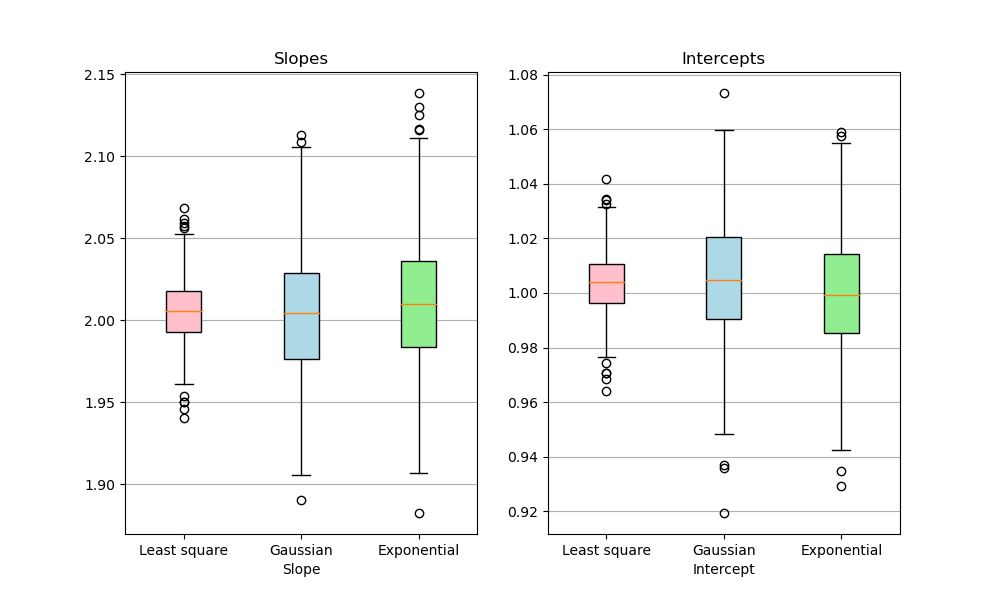

In [56]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))

# rectangular box plot
bplot1 = axes[0].boxplot(SLOP,
                         vert=True,  
                         patch_artist=True, 
                         labels=labels)  
axes[0].set_title('Slopes')


bplot2 = axes[1].boxplot(INTER,
                         vert=True, 
                         patch_artist=True,
                         labels=labels) 
axes[1].set_title('Intercepts')

colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

for ind,ax in enumerate(axes):
    ax.yaxis.grid(True)
    if ind == 0:
        ax.set_xlabel('Slope')
    else:
        ax.set_xlabel('Intercept')

plt.show()

The least squared with boostrap method seems to be more precise than both of the MCMC runs having a standard deviation lower than the rest, this may due to the high number of iterations (1000 iterations for a dataset of 100 points). The method using exponential residuals seems to have the same dispersion as the Gaussian method but is a bit more offset compared to the desired results.


In [57]:
# Computation of the cost function of the best solution for each method
def regrcost(x,y,a,b):
    cost = np.sqrt(np.sum((y-a*x-b)**2))
    return cost

SLOP = [slopes, ag, ae]
INTER = [intercepts, bg, be]

sumgcost = regrcost(my_problemLR.Xi,my_problemLR.Yi, mMAP_gauss[0], mMAP_gauss[1])
sumecost = regrcost(my_problemLR.Xi,my_problemLR.Yi, mMAP_exp[0], mMAP_exp[1])
sumbcost = regrcost(my_problemLR.Xi,my_problemLR.Yi, np.mean(slopes), np.mean(intercepts))

costs = [sumgcost, sumecost, sumbcost]

<IPython.core.display.Javascript object>


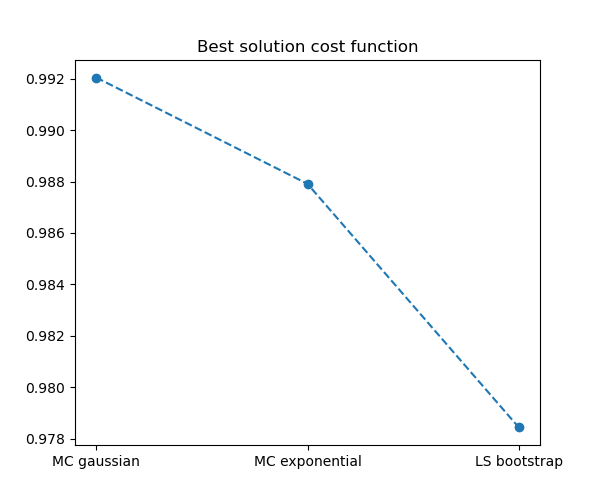

Text(0.5, 1.0, 'Best solution cost function')

In [58]:
plt.figure(figsize=(6, 5))
plt.plot(costs, 'o--')
plt.xticks([0, 1, 2], ['MC gaussian','MC exponential','LS bootstrap'])
plt.title('Best solution cost function')

In conclusion, the least squared method seems to be more consistent with less dispersion whilst still being very close to the results.